In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/german-credit-data-with-risk/german_credit_data.csv


In [2]:
#Load librariess
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn

import plotly
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from collections import Counter # To do counter of some features

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.metrics import precision_score, recall_score, f1_score, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, confusion_matrix, roc_curve, plot_roc_curve


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.feature_selection import SelectPercentile, RFE

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

import warnings # This library will be used to ignore some warnings
warnings.simplefilter("ignore")

In [3]:
#Importing the data
df = pd.read_csv("../input/german-credit-data-with-risk/german_credit_data.csv",index_col=0)

# 1. Data Overview

In [4]:
# Look at some of the data
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [5]:
# Looking at the data types, unique samples, and number of unique samples
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

report(df)

,Column,d_type,unique_sample,n_uniques
0,Age,int64,"[67, 22, 49, 45, 53]",53
1,Sex,object,"[male, female]",2
2,Job,int64,"[2, 1, 3, 0]",4
3,Housing,object,"[own, free, rent]",3
4,Saving accounts,object,"[nan, little, quite rich, rich, moderate]",4
5,Checking account,object,"[little, moderate, nan, rich]",3
6,Credit amount,int64,"[1169, 5951, 2096, 7882, 4870]",921
7,Duration,int64,"[6, 48, 12, 42, 24]",33
8,Purpose,object,"[radio/TV, education, furniture/equipment, car...",8
9,Risk,object,"[good, bad]",2


Job feature listed as int64 type, but it is actually categorical. The numeric form of this feature is encoded from the categorical form.

In [6]:
df = df.astype({'Job': 'object'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(3), object(7)
memory usage: 85.9+ KB


In [7]:
# Check percentage of null values per column
def color_null_red(val):
    color = 'red' if val > 0 else 'black'
    return 'color: %s' % color

pd.DataFrame(df.isna().sum()/len(df)*100, columns= ['%Null']).sort_values('%Null', ascending=False).style.applymap(color_null_red, subset=['%Null'])

,%Null
Checking account,39.400000
Saving accounts,18.300000
Age,0.000000
Sex,0.000000
Job,0.000000
Housing,0.000000
Credit amount,0.000000
Duration,0.000000
Purpose,0.000000
Risk,0.000000


In [8]:
# Data types
categoric = df.select_dtypes(include='object').columns.tolist()
numeric = df.select_dtypes(include='int64').columns.tolist()
print(f'Categorical features: {categoric}')
print(f'Numerical features: {numeric}')

Categorical features: ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
Numerical features: ['Age', 'Credit amount', 'Duration']


> ##### Summary:
> - The data contain __1000 rows__ and __10 features__
> - The data contain __3 numerical features__ (Age, Credit amount, Duration) and __6 categorical values__ (Sex, Job, Housing, Saving accounts, Checking account, Purpose, Risk) after the adjustment
> - The data __contain null values__: Checking account (39.4% null) and Saving accounts (18.3% null)
<br>

# 2. EDA

#### Good/Bad Risk

> ##### Summary:
> The proportion of Bad and Good loans in our data is 7:3. Since the data is imbalance, I will do oversampling using SMOTE in Modeling section.  
<br>

In [9]:
labels = ["Good", "Bad"]
count_good = df[df["Risk"]== 'good']["Risk"].value_counts().values[0]
count_bad = df[df["Risk"]== 'bad']["Risk"].value_counts().values[0]

fig = go.Figure(go.Pie(labels=labels, values=[count_good,count_bad], scalegroup='one'))
fig.update_layout(title_text='Proportion Bad/Good')
fig.show()

> ##### Summary:
> The proportion of Bad and Good loans in our data is 7:3. Since the data is imbalance, I will do oversampling using SMOTE in Modeling section.  
<br>

In [10]:
# num_feat = df.select_dtypes(include=['int64','float64']).columns.to_list()

# plt.style.use('ggplot')
# plt.figure(figsize = (20, 15))

# for i in range(len(num_feat)):
#     plt.subplot(2, 2, i+1)
#     sns.distplot(df[num_feat[i]][df['Risk'] == 'bad'])
#     sns.distplot(df[num_feat[i]][df['Risk'] == 'good'])

#### Age

Summary:
- The younger customers tend to default the credits
- Bad credit on Elder, Senior, and Higher group tend to have higher credit amount. It means the higher the credit amount, the higher the chance to default. But let's see next when we explore the Credit Amount feature.
- The 'Young' age group (19-29) has the highest probability of default. Around 37% of the credit proposed by this age group is categorized as Bad Credit. Meanwhile, this age group is the most in proposing credits. The lender must be aware of the customers from this age group. 
<br>

In [11]:
df_good = df.loc[df['Risk']=='good']['Age'].values.tolist()
df_bad = df.loc[df['Risk']=='bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#  First plot
trace0 = go.Histogram(x=df_good,
                     histnorm='probability',
                      name='Good Credit')

#  Second plot
trace1 = go.Histogram(x=df_bad,
                     histnorm='probability',
                      name='Bad Credit')

#  Third plot
trace2 = go.Histogram(x=df_age,
                     histnorm='probability',
                      name='Overall Age')

# Creating the grid
fig = plotly.subplots.make_subplots(rows=2, cols=2, specs=[[{},{}], [{'colspan':2}, None]], subplot_titles=('Good','Bad','General Distribution'))

# Setting the figs
fig.append_trace(trace0, 1,1)
fig.append_trace(trace1, 1,2)
fig.append_trace(trace2, 2,1)

fig['layout'].update(showlegend=True, title='Age Distribution', bargap=0.05)
fig.show()

In [12]:
df_good = df.loc[df['Risk']=='good']['Age'].values.tolist()
df_bad = df.loc[df['Risk']=='bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#  First plot
trace0 = go.Histogram(x=df_good,
                     histnorm='probability',
                      name='Good Credit')

#  Second plot
trace1 = go.Histogram(x=df_bad,
                     histnorm='probability',
                      name='Bad Credit')

# Group data together
hist_data = [df_good, df_bad]

group_labels = ['Good Risk','Bad Risk']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, colors=['dodgerblue','crimson'])
fig.layout.update({'title': 'Distribution Plot of Bad/Good Risk by Age'})
fig.show()

In [13]:
df_good = df.loc[df['Risk']=='good']['Age'].values.tolist()
df_bad = df.loc[df['Risk']=='bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#  First plot
trace0 = go.Histogram(x=df_good,
                     histnorm='probability',
                      name='Good Credit')

#  Second plot
trace1 = go.Histogram(x=df_bad,
                     histnorm='probability',
                      name='Bad Credit')

data = [trace0, trace1]
layout = go.Layout(title='Number of Loan by Age', title_x=0.5)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Age-BadGood')

##### Grouping/Binning Age Feature
We will group the age feature and name it to categorical feature. By grouping, it will be easier to see the patterns of which loans were high risk.  The grouping scheme will be like below:
- Young: Clients age ranges from (19 - 29).
- Young Adults: Clients age ranges from (30-40)
- Senior: Clients age ranges from (41-55)
- Elder: Clients age is more than 55 years old

In [14]:
interval = (18, 29, 40, 55, 120)

cats = ['Young', 'Young Adults', 'Senior', 'Elder']
df["Age_Group"] = pd.cut(df['Age'], interval, labels=cats)


df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_Group
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,Elder
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,Young
2,49,male,1,own,little,NaN,2096,12,education,good,Senior
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,Senior
4,53,male,2,free,little,little,4870,24,car,bad,Senior
...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good,Young Adults
996,40,male,3,own,little,little,3857,30,car,good,Young Adults
997,38,male,2,own,little,NaN,804,12,radio/TV,good,Young Adults
998,23,male,2,free,little,little,1845,45,radio/TV,bad,Young


In [15]:
##################### ANNOTATION #####################
order = ['Young Adults','Young','Senior','Elder']
y1 = df[df['Risk']=='good']['Age_Group'].value_counts().values
y2 = df[df['Risk']=='bad']['Age_Group'].value_counts().reindex(order).values

percentage_good = y1/(y1+y2)*100
percentage_good =  [round(num, 2) for num in percentage_good]
percentage_good =  [str(num) for num in percentage_good]

percentage_bad = y2/(y1+y2)*100
percentage_bad =  [round(num, 2) for num in percentage_bad]
percentage_bad =  [str(num) for num in percentage_bad]

##################### BAR PLOT #####################
trace0 = go.Bar(x = order,
               y = df[df['Risk']=='good']['Age_Group'].value_counts().values,
               name='Good credit',
               text=[percentage_good[0] + '%', percentage_good[1] + '%', percentage_good[2] + '%', percentage_good[3] + '%'],
               textposition = "outside",
               textfont_size=9,
               )

trace1 = go.Bar(x = order,
               y = df[df['Risk']=='bad']['Age_Group'].value_counts().values,
               name='Bad credit',
               text=[percentage_bad[0] + '%', percentage_bad[1] + '%', percentage_bad[2] + '%', percentage_bad[3] + '%'],
               textposition = "outside",
               textfont_size=9)

##################### BOX PLOT #####################
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace2 = go.Box(
    x=df_good['Age_Group'],
    y=df_good['Credit amount'],
    name='Good credit')

trace3 = go.Box(
    x=df_bad['Age_Group'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker= dict(color='crimson'))


##################### APPEND PLOT #####################
data = [trace0, trace1, trace2,trace3]


fig = plotly.subplots.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Age Group Count', 'Credit Amount by Age Group'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(uniformtext_minsize=8, uniformtext_mode='hide', boxmode='group')
py.iplot(fig, filename='age-group-subplot')

In [16]:
# trace0 = go.Box(
#     x=df_good['Age_Group'],
#     y=df_good['Credit amount'],
#     name='Good credit')

# trace1 = go.Box(
#     x=df_bad['Age_Group'],
#     y=df_bad['Credit amount'],
#     name='Bad credit')

# data = [trace0, trace1]

# layout = go.Layout(
#     yaxis=dict(title='Credit Amount (USD)'),
#     xaxis=dict(title='Age Group'),
#     boxmode='group')

# fig = go.Figure(data=data, layout=layout)

# py.iplot(fig, filename='age-group-credit-amount')

In [17]:
# y1 = df[df['Risk']=='good']['Age_Group'].value_counts().values
# y2 = df[df['Risk']=='bad']['Age_Group'].value_counts().reindex(['Young Adults','Young','Senior','Elder']).values

# percentage_good = y1/(y1+y2)*100
# percentage_good =  [round(num, 2) for num in percentage_good]
# percentage_good =  [str(num) for num in percentage_good]

# percentage_bad = y2/(y1+y2)*100
# percentage_bad =  [round(num, 2) for num in percentage_bad]
# percentage_bad =  [str(num) for num in percentage_bad]

# # First plot
# trace0 = go.Bar(
#                 x = df[df['Risk']=='good']['Age_Group'].value_counts().index.values,
#                 y = df[df['Risk']=='good']['Age_Group'].value_counts().values,
#                 name='Good credit',
#                 text=[percentage_good[0] + '%', percentage_good[1] + '%', percentage_good[2] + '%', percentage_good[3] + '%'],
#                 textposition = 'auto'
#                )

# # Second plot
# trace1 = go.Bar(
#                 x = df[df['Risk']=='bad']['Age_Group'].value_counts().index.values,
#                 y = df[df['Risk']=='bad']['Age_Group'].value_counts().values,
#                 name='Bad credit',
#                 text=[percentage_bad[1] + '%', percentage_bad[0] + '%', percentage_bad[2] + '%', percentage_bad[3] + '%'],
#                 textposition = 'auto'
#                 )

# data = [trace0, trace1]

# layout = go.Layout(title='Number of Loan by Age Group', title_x=0.5)

# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='Age-Grouped-BadGood')

In [18]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace0 = go.Box(
    x=df_good['Age_Group'],
    y=df_good['Duration'],
    name='Good credit')

trace1 = go.Box(
    x=df_bad['Age_Group'],
    y=df_bad['Duration'],
    name='Bad credit')

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(title='Duration (Month)'),
    xaxis=dict(title='Age Group'),
    boxmode='group',
    title='Credit Application by Age Group and Duration')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='age-group-duration')

In [19]:
pd.crosstab(index=df['Saving accounts'], columns=df['Checking account'], normalize=0)

Checking account,little,moderate,rich
Saving accounts,,,
little,0.531553,0.368932,0.099515
moderate,0.187500,0.734375,0.078125
quite rich,0.347826,0.478261,0.173913
rich,0.260870,0.608696,0.130435


In [20]:
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df['Age_Group'], columns='Total').style.background_gradient(cmap = cm)

col_0,Total
Age_Group,
Young,371
Young Adults,355
Senior,203
Elder,71


#### Sex

Summary:
- The 
- 
<br>

In [21]:
labels = ["Male", "Female"]
count_good = df[df["Sex"]== 'male']["Sex"].value_counts().values[0]
count_bad = df[df["Sex"]== 'female']["Sex"].value_counts().values[0]

fig = go.Figure(go.Pie(labels=labels, values=[count_good,count_bad], scalegroup='one'))
fig.update_layout(title_text='Proportion of Sex')
fig.show()

In [22]:
y1 = df[df['Risk']=='good']['Sex'].value_counts().values
y2 = df[df['Risk']=='bad']['Sex'].value_counts().values

percentage_good = y1/(y1+y2)*100
percentage_good =  [round(num, 2) for num in percentage_good]
percentage_good =  [str(num) for num in percentage_good]

percentage_bad = y2/(y1+y2)*100
percentage_bad =  [round(num, 2) for num in percentage_bad]
percentage_bad =  [str(num) for num in percentage_bad]

In [23]:
##################### BAR PLOT #####################
trace0 = go.Bar(x = df[df['Risk']=='good']['Sex'].value_counts().index.values,
               y = df[df['Risk']=='good']['Sex'].value_counts().values,
               name='Good credit',
               text=[percentage_good[0] + '%', percentage_good[1] + '%'],
               textposition = 'auto')

trace1 = go.Bar(x = df[df['Risk']=='bad']['Sex'].value_counts().index.values,
               y = df[df['Risk']=='bad']['Sex'].value_counts().values,
               name='Bad credit',
               text=[percentage_bad[0] + '%', percentage_bad[1] + '%'],
               textposition = 'auto')

##################### BOX PLOT #####################
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace2 = go.Box(
    x=df_good['Sex'],
    y=df_good['Credit amount'],
    name='Good credit')

trace3 = go.Box(
    x=df_bad['Sex'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker= dict(color='crimson'))


##################### APPEND PLOT #####################
data = [trace0, trace1, trace2,trace3]


fig = plotly.subplots.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(boxmode='group')
py.iplot(fig, filename='sex-subplot')

In [24]:
df_male = df.loc[df['Sex']=='male']['Age'].values.tolist()
df_female = df.loc[df['Sex']=='female']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#  First plot
trace0 = go.Histogram(x=df_male,
                     histnorm='probability',
                      name='Male')

#  Second plot
trace1 = go.Histogram(x=df_female,
                     histnorm='probability',
                      name='Female')

# Creating the grid
fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=('Male','Female'))

# Setting the figs
fig.append_trace(trace0, 1,1)
fig.append_trace(trace1, 1,2)

fig['layout'].update(showlegend=True, title='Age and Sex Distribution', bargap=0.05)
fig.show()

In [25]:
# First plot
trace0 = go.Bar(x = df[df['Sex']=='male']['Purpose'].value_counts().index.values,
               y = df[df['Sex']=='male']['Purpose'].value_counts().values,
               name='Male',
               marker= dict(color='rgb(72, 92, 238)'))

# Second plot
trace1 = go.Bar(x = df[df['Sex']=='female']['Purpose'].value_counts().index.values,
               y = df[df['Sex']=='female']['Purpose'].value_counts().values,
               name='Female',
               marker= dict(color='rgb(217, 128, 234)'))

data = [trace0, trace1]

layout = go.Layout(
    title='Credits Reasons by Sex'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='credits_reasons_by_sex')

#### Job

In [26]:
##################### ANNOTATION #####################
y1 = df[df['Risk']=='good']['Job'].value_counts().values
y2 = df[df['Risk']=='bad']['Job'].value_counts().values

percentage_good = y1/(y1+y2)*100
percentage_good =  [round(num, 2) for num in percentage_good]
percentage_good =  [str(num) for num in percentage_good]

percentage_bad = y2/(y1+y2)*100
percentage_bad =  [round(num, 2) for num in percentage_bad]
percentage_bad =  [str(num) for num in percentage_bad]

##################### BAR PLOT #####################
trace0 = go.Bar(x = df[df['Risk']=='good']['Job'].value_counts().index.values,
               y = df[df['Risk']=='good']['Job'].value_counts().values,
               name='Good credit',
               text=[percentage_good[0] + '%', percentage_good[1] + '%', percentage_good[2] + '%', percentage_good[3] + '%'],
               textposition = "outside",
               textfont_size=9,
               )

trace1 = go.Bar(x = df[df['Risk']=='bad']['Job'].value_counts().index.values,
               y = df[df['Risk']=='bad']['Job'].value_counts().values,
               name='Bad credit',
               text=[percentage_bad[0] + '%', percentage_bad[1] + '%', percentage_bad[2] + '%', percentage_bad[3] + '%'],
               textposition = "outside",
               textfont_size=9)

##################### BOX PLOT #####################
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace2 = go.Box(
    x=df_good['Job'],
    y=df_good['Credit amount'],
    name='Good credit')

trace3 = go.Box(
    x=df_bad['Job'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker= dict(color='crimson'))


##################### APPEND PLOT #####################
data = [trace0, trace1, trace2,trace3]


fig = plotly.subplots.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Job Count', 'Credit Amount by Job'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(uniformtext_minsize=8, uniformtext_mode='hide', boxmode='group')
py.iplot(fig, filename='job-subplot')

In [27]:
fig = {
    "data": [
        {
            "type": 'violin',
            "x": df_good['Job'],
            "y": df_good['Age'],
            "legendgroup": 'Good Credit',
            "scalegroup": 'No',
            "name": 'Good Credit',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'dodgerblue'
            }
        },
        {
            "type": 'violin',
            "x": df_bad['Job'],
            "y": df_bad['Age'],
            "legendgroup": 'Bad Credit',
            "scalegroup": 'No',
            "name": 'Bad Credit',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'crimson'
            }
        }
    ],
    "layout" : {
        "yaxis": {
            "zeroline": False,
        },
        "violingap": 0,
        "violinmode": "overlay"
    }
}


py.iplot(fig, filename = 'Age-Housing', validate = False)

#### Housing

In [28]:
##################### ANNOTATION #####################
y1 = df[df['Risk']=='good']['Housing'].value_counts().values
y2 = df[df['Risk']=='bad']['Housing'].value_counts().values

percentage_good = y1/(y1+y2)*100
percentage_good =  [round(num, 2) for num in percentage_good]
percentage_good =  [str(num) for num in percentage_good]

percentage_bad = y2/(y1+y2)*100
percentage_bad =  [round(num, 2) for num in percentage_bad]
percentage_bad =  [str(num) for num in percentage_bad]

##################### BAR PLOT #####################
trace0 = go.Bar(x = df[df['Risk']=='good']['Housing'].value_counts().index.values,
               y = df[df['Risk']=='good']['Housing'].value_counts().values,
               name='Good credit',
               text=[percentage_good[0] + '%', percentage_good[1] + '%', percentage_good[2] + '%'],
               textposition = "outside",
               textfont_size=9,
               )

trace1 = go.Bar(x = df[df['Risk']=='bad']['Housing'].value_counts().index.values,
               y = df[df['Risk']=='bad']['Housing'].value_counts().values,
               name='Bad credit',
               text=[percentage_bad[0] + '%', percentage_bad[1] + '%', percentage_bad[2] + '%'],
               textposition = "outside",
               textfont_size=9)

##################### BOX PLOT #####################
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace2 = go.Box(
    x=df_good['Housing'],
    y=df_good['Credit amount'],
    name='Good credit')

trace3 = go.Box(
    x=df_bad['Housing'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker= dict(color='crimson'))


##################### APPEND PLOT #####################
data = [trace0, trace1, trace2,trace3]


fig = plotly.subplots.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Housing Count', 'Credit Amount by Housing'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(boxmode='group')
py.iplot(fig, filename='housing-subplot')

#### Wealth Analysis

In this section I explore Saving accounts and Checking account. <br>
Summary:
- Customers with 'little' saving and checking account have a higher probability to default the loans
- It is unique that customers with 'rich' tend to propose the lower credit amount comparing to moderate and little checking account customers. This group of customer ('rich' checking account) also has the lowest default probability.
- Customers with 'Little' and 'Moderate' checking account tend to apply loans in higher duration than the 'Rich'. They also have probability to default over 40%. Bank must be aware of these type of customer.

In [29]:
##################### ANNOTATION #####################
y1 = df[df['Risk']=='good']['Saving accounts'].value_counts().values
y2 = df[df['Risk']=='bad']['Saving accounts'].value_counts().values

percentage_good = y1/(y1+y2)*100
percentage_good =  [round(num, 2) for num in percentage_good]
percentage_good =  [str(num) for num in percentage_good]

percentage_bad = y2/(y1+y2)*100
percentage_bad =  [round(num, 2) for num in percentage_bad]
percentage_bad =  [str(num) for num in percentage_bad]

##################### BAR PLOT #####################
trace0 = go.Bar(x = df[df['Risk']=='good']['Saving accounts'].value_counts().index.values,
               y = df[df['Risk']=='good']['Saving accounts'].value_counts().values,
               name='Good credit',
               text=[percentage_good[0] + '%', percentage_good[1] + '%', percentage_good[2] + '%', percentage_good[3] + '%'],
               textposition = "outside",
               textfont_size=9,
               )

trace1 = go.Bar(x = df[df['Risk']=='bad']['Saving accounts'].value_counts().index.values,
               y = df[df['Risk']=='bad']['Saving accounts'].value_counts().values,
               name='Bad credit',
               text=[percentage_bad[0] + '%', percentage_bad[1] + '%', percentage_bad[2] + '%', percentage_bad[3] + '%'],
               textposition = "outside",
               textfont_size=9)

##################### BOX PLOT #####################
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace2 = go.Box(
    x=df_good['Saving accounts'],
    y=df_good['Credit amount'],
    name='Good credit')

trace3 = go.Box(
    x=df_bad['Saving accounts'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker= dict(color='crimson'))


##################### APPEND PLOT #####################
data = [trace0, trace1, trace2,trace3]


fig = plotly.subplots.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Saving accounts Count', 'Credit Amount by Saving accounts'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(boxmode='group')
py.iplot(fig, filename='Saving-accounts-subplot')

In [30]:
##################### ANNOTATION #####################
y1 = df[df['Risk']=='good']['Checking account'].value_counts().values
y2 = df[df['Risk']=='bad']['Checking account'].value_counts().values

percentage_good = y1/(y1+y2)*100
percentage_good =  [round(num, 2) for num in percentage_good]
percentage_good =  [str(num) for num in percentage_good]

percentage_bad = y2/(y1+y2)*100
percentage_bad =  [round(num, 2) for num in percentage_bad]
percentage_bad =  [str(num) for num in percentage_bad]

##################### BAR PLOT #####################
trace0 = go.Bar(x = df[df['Risk']=='good']['Checking account'].value_counts().index.values,
               y = df[df['Risk']=='good']['Checking account'].value_counts().values,
               name='Good credit',
               text=[percentage_good[0] + '%', percentage_good[1] + '%', percentage_good[2] + '%'],
               textposition = "outside",
               textfont_size=9,
               )

trace1 = go.Bar(x = df[df['Risk']=='bad']['Checking account'].value_counts().index.values,
               y = df[df['Risk']=='bad']['Checking account'].value_counts().values,
               name='Bad credit',
               text=[percentage_bad[0] + '%', percentage_bad[1] + '%', percentage_bad[2] + '%'],
               textposition = "outside",
               textfont_size=9)

##################### BOX PLOT #####################
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace2 = go.Box(
    x=df_good['Checking account'],
    y=df_good['Credit amount'],
    name='Good credit')

trace3 = go.Box(
    x=df_bad['Checking account'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker= dict(color='crimson'))


##################### APPEND PLOT #####################
data = [trace0, trace1, trace2,trace3]


fig = plotly.subplots.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Checking account Count', 'Credit Amount by Checking account'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(boxmode='group')
py.iplot(fig, filename='Checking-account-subplot')

In [31]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace0 = go.Box(
    x=df_good['Checking account'],
    y=df_good['Duration'],
    name='Good credit')

trace1 = go.Box(
    x=df_bad['Checking account'],
    y=df_bad['Duration'],
    name='Bad credit')

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(title='Duration (Month)'),
    xaxis=dict(title='Checking account'),
    boxmode='group',
    title='Credit Application by Checking account and Duration')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Checking-account-duration')

#### Credit Amount and Duration

Summary:
- Bad risk credits tend to occur in __the higher duration of credits and higher credit amount__
- Credit amount and Duration have strong positive correlation (0.625). This means the higher the credit, the higher the duration also. 

In [32]:
df_good = df.loc[df['Risk']=='good']['Duration'].values.tolist()
df_bad = df.loc[df['Risk']=='bad']['Duration'].values.tolist()
df_age = df['Duration'].values.tolist()

#  First plot
trace0 = go.Histogram(x=df_good,
                     histnorm='probability',
                      name='Good Credit')

#  Second plot
trace1 = go.Histogram(x=df_bad,
                     histnorm='probability',
                      name='Bad Credit')

data = [trace0, trace1]
layout = go.Layout(title='Number of Loan by Duration', title_x=0.5)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Duration-BadGood')

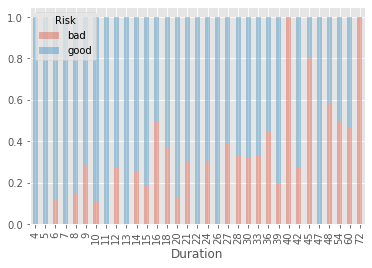

In [33]:
plt.style.use('ggplot')
pd.crosstab(index=df['Duration'], columns=df['Risk'], normalize=0).plot(kind='bar', stacked=True, alpha=0.4)
plt.show()

In [34]:
##################### PLOT 1 #####################
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace0 = go.Box(
    x=df_good['Risk'],
    y=df_good['Duration'],
    name='Good credit')

trace1 = go.Box(
    x=df_bad['Risk'],
    y=df_bad['Duration'],
    name='Bad credit')

##################### PLOT 2 #####################
trace2 = go.Box(
    x=df_good['Risk'],
    y=df_good['Credit amount'],
    name='Good credit')

trace3 = go.Box(
    x=df_bad['Risk'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker= dict(color='crimson'))

##################### APPEND PLOT #####################
data = [trace0, trace1, trace2,trace3]


fig = plotly.subplots.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Duration', 'Credit Amount'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(boxmode='group', title='<b>Boxplot of Duration and Credit Amount</b>', title_x=0.5)
py.iplot(fig, filename='Checking-account-subplot')

##### Credit Amount vs Duration

In [35]:
fig = px.scatter(df, x="Duration", y="Credit amount", color="Risk"
#                  ,size='Age' 
                 ,hover_data=['Age_Group','Purpose','Checking account']
                )
fig.show()

In [36]:
corr_credit_duration = df[['Credit amount','Duration']]
corr_credit_duration.corr('spearman')

,Credit amount,Duration
Credit amount,1.000000,0.624709
Duration,0.624709,1.000000


##### Credit amount vs Age

In [37]:
fig = px.scatter(df, x="Age", y="Credit amount", color="Risk"
#                  ,size='Age' 
                 ,hover_data=['Age_Group','Purpose','Checking account']
                )
fig.show()

#### Credit by Purpose

Summary:
- Bad risk credits tend to occur in __the higher duration of credits and higher credit amount__
- Credit amount and Duration have strong positive correlation (0.625). This means the higher the credit, the higher the duration also. 

In [38]:
##################### ANNOTATION #####################
y1 = df[df['Risk']=='good']['Purpose'].value_counts().values
y2 = df[df['Risk']=='bad']['Purpose'].value_counts().values

percentage_good = y1/(y1+y2)*100
percentage_good =  [round(num, 2) for num in percentage_good]
percentage_good =  [str(num) for num in percentage_good]

percentage_bad = y2/(y1+y2)*100
percentage_bad =  [round(num, 2) for num in percentage_bad]
percentage_bad =  [str(num) for num in percentage_bad]

##################### BAR PLOT #####################
trace0 = go.Bar(x = df[df['Risk']=='good']['Purpose'].value_counts().index.values,
               y = df[df['Risk']=='good']['Purpose'].value_counts().values,
               name='Good credit',
#                text=[percentage_good[0] + '%', percentage_good[1] + '%', percentage_good[2] + '%'],
               textposition = "outside",
               textfont_size=9,
               )

trace1 = go.Bar(x = df[df['Risk']=='bad']['Purpose'].value_counts().index.values,
               y = df[df['Risk']=='bad']['Purpose'].value_counts().values,
               name='Bad credit',
#                text=[percentage_bad[0] + '%', percentage_bad[1] + '%', percentage_bad[2] + '%'],
               textposition = "outside",
               textfont_size=9)

data = [trace0, trace1]
layout = go.Layout(title='Number of Loan by Purpose', title_x=0.5)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Purpose-BadGood')

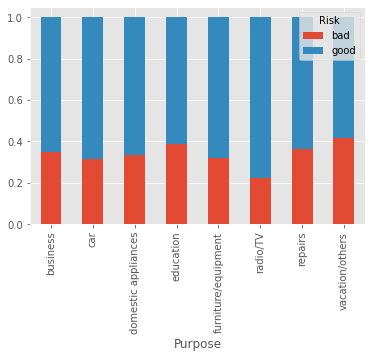

In [39]:
plt.style.use('ggplot')
pd.crosstab(index=df['Purpose'], columns=df['Risk'], normalize=0).plot(kind='bar', stacked=True)
plt.show()

In [40]:
# Cmap for table
red_cmap = sns.light_palette("tomato", as_cmap=True)

# Value counts table (1)
purpose_valuecounts = pd.DataFrame(df['Purpose'].value_counts()).reset_index()
purpose_valuecounts = purpose_valuecounts.rename(columns={'index':'Purpose','Purpose':'Total'})

# Risk percentage table (2)
risk_percentage_purpose = pd.crosstab(index=df['Risk'], columns=df['Purpose'], normalize=1).reset_index(drop = True)
risk_percentage_purpose.columns.name = None
risk_percentage_purpose = risk_percentage_purpose.T.reset_index().rename(columns={'index':'Purpose', 0:'bad_perc',1:'good_perc'})
risk_percentage_purpose

# Merge table 1 and 2
risk_percentage_purpose = risk_percentage_purpose.merge(purpose_valuecounts, how='inner')
risk_percentage_purpose.sort_values('Total').style.background_gradient(cmap = red_cmap, subset='bad_perc')

,Purpose,bad_perc,good_perc,Total
2,domestic appliances,0.333333,0.666667,12
7,vacation/others,0.416667,0.583333,12
6,repairs,0.363636,0.636364,22
3,education,0.389831,0.610169,59
0,business,0.350515,0.649485,97
4,furniture/equipment,0.320442,0.679558,181
5,radio/TV,0.221429,0.778571,280
1,car,0.314540,0.685460,337


In [41]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace0 = go.Box(
    x=df_good['Purpose'],
    y=df_good['Duration'],
    name='Good credit')

trace1 = go.Box(
    x=df_bad['Purpose'],
    y=df_bad['Duration'],
    name='Bad credit')

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(title='Purpose'),
    xaxis=dict(title='Checking account'),
    boxmode='group',
    title='Credit Application by Purpose and Duration')

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='purpose-duration')

# 3. Modeling

## Splitting

In [42]:
df_modeling = df.copy()
df_modeling['Risk'] = np.where(df_modeling['Risk']=='bad',1,0)

In [43]:
X = df_modeling.drop(columns=['Risk','Age_Group'])
y = df_modeling['Risk']
y.head()

0    0
1    1
2    0
3    0
4    1
Name: Risk, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size = 0.2, 
    random_state = 2021)

## Preprocessing

In [45]:
df[(df['Saving accounts'].isna()) | (df['Checking account'].isna())]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_Group
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,Elder
2,49,male,1,own,little,NaN,2096,12,education,good,Senior
5,35,male,1,free,NaN,NaN,9055,36,education,good,Young Adults
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good,Senior
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good,Elder
...,...,...,...,...,...,...,...,...,...,...,...
991,34,male,1,own,moderate,NaN,1569,15,radio/TV,good,Young Adults
992,23,male,1,rent,NaN,little,1936,18,radio/TV,good,Young
994,50,male,2,own,NaN,NaN,2390,12,car,good,Senior
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good,Young Adults


Preprocessing strategy:
- Replace NaN value with 'Undefined' since the percentage of null values in Saving account and Checing account features are huge (48%). If we remove them, we will lose too many information.
- One hot encoding for categorical features
- Robust Scaler for numerical features
- Feature selection using Recursive Feature Eelemination (RFE)
- Oversampling using SMOTE

In [46]:
smote = SMOTE(random_state=2021)

In [47]:
# Split numerical and categorical data
cat = X.select_dtypes(include='object').columns.tolist()
num = X.select_dtypes(include='int64').columns.tolist()

# Make pipeline for categorical features
cat_scalerencoder_pipe = Pipeline([
    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'undefined')),
    ('one hot encoder', OneHotEncoder())
])

# Column transformer
transformer = ColumnTransformer([
    ('cat pipe', cat_scalerencoder_pipe, cat),
    ('num pipe', RobustScaler(), num)])

In [48]:
# Model assignment
logreg = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xgbc = XGBClassifier()
knn = KNeighborsClassifier()

models = [logreg, dtc, rfc, gbc, xgbc, knn]
model_name = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 
              'XGBClassifier','KNeighborsClassifier']

In [49]:
# Combine all pipeline. Assign in to a list
all_models = []
for i in models:
    modelpipe = Pipeline([
        ('transformer', transformer)
        ,('resampling', smote)
        ,('rfe', RFE(logreg))
        ,('clf',i)])
    all_models.append(modelpipe)

## Modeling

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


1. FN is a condition when the __MODEL__ predict THE RISK IS GOOD __(0)__ but __ACTUALLY__ THE RISK IS BAD __(1)__
    - High numbers of FN will cause __money loss__ due to the money lent is not returned by customers. 


2. FP is a condition when the __MODEL__ predict THE RISK IS BAD __(1)__ but __ACTUALLY__ THE RISK IS GOOD __(0)__
    - High numbers of FP will cause __unoptimal revenue__ because the bank fails to take advantage of opportunities to lend money to the right customers


<img src="https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg" alt="Hotel Lobby" style="width:690px;height:345px;">

In [50]:
skfold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)

logit_score = cross_val_score(all_models[0], X_train, y_train, scoring='accuracy', cv=skfold, n_jobs=-1, verbose=1)
dtc_score = cross_val_score(all_models[1], X_train, y_train, scoring='accuracy', cv=skfold, n_jobs=-1, verbose=1)
rfc_score = cross_val_score(all_models[2], X_train, y_train, scoring='accuracy', cv=skfold, n_jobs=-1, verbose=1)
gbc_score = cross_val_score(all_models[3], X_train, y_train, scoring='accuracy', cv=skfold, n_jobs=-1, verbose=1)
xgbc_score = cross_val_score(all_models[4], X_train, y_train, scoring='accuracy', cv=skfold, n_jobs=-1, verbose=1)
knn_score = cross_val_score(all_models[5], X_train, y_train, scoring='accuracy', cv=skfold, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [51]:
# Cross validation score
crosval_results = [logit_score,dtc_score,rfc_score,gbc_score,xgbc_score,knn_score]
pd.DataFrame(crosval_results, index=model_name)

,0,1,2,3,4
LogisticRegression,0.70000,0.65000,0.64375,0.73750,0.67500
DecisionTreeClassifier,0.70000,0.61875,0.66250,0.76875,0.67500
RandomForestClassifier,0.74375,0.68750,0.68750,0.76250,0.71250
GradientBoostingClassifier,0.72500,0.68125,0.66250,0.78125,0.68750
XGBClassifier,0.74375,0.66250,0.68125,0.75625,0.72500
KNeighborsClassifier,0.69375,0.63125,0.65000,0.66875,0.68125


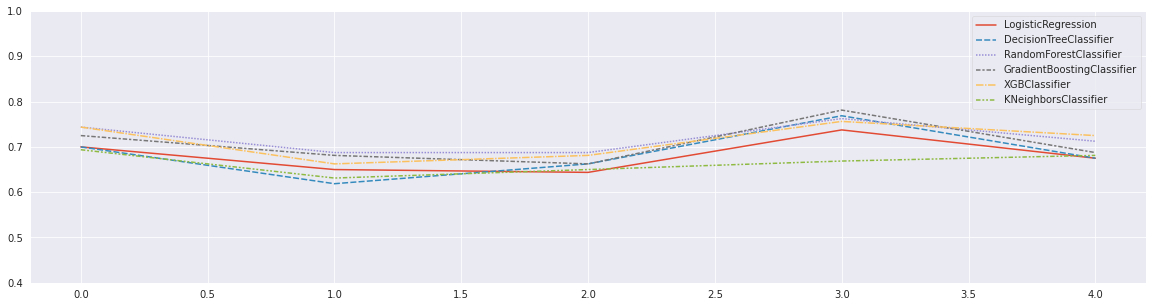

In [52]:
# Plot cross validation score
sns.set_style('darkgrid')
plt.figure(figsize=(20,5))
plt.ylim(0.4, 1)
sns.lineplot(data=pd.DataFrame(crosval_results, index=model_name).T)
plt.show()

In [53]:
# Cross validation score mean and std
crosval_results_mean = [logit_score.mean(),dtc_score.mean(),rfc_score.mean(),gbc_score.mean(),xgbc_score.mean(),knn_score.mean()]
crosval_results_std = [logit_score.std(),dtc_score.std(),rfc_score.std(),gbc_score.std(),xgbc_score.std(),knn_score.std()]
pd.DataFrame({'score_mean':crosval_results_mean, 'score_std':crosval_results_std}, index=model_name)

,score_mean,score_std
LogisticRegression,0.68125,0.034460
DecisionTreeClassifier,0.68500,0.049466
RandomForestClassifier,0.71875,0.030104
GradientBoostingClassifier,0.70750,0.042094
XGBClassifier,0.71375,0.036099
KNeighborsClassifier,0.66500,0.022220


In [54]:
# Fit and predict
tr_score = []
ts_score = []
default_models = []

skf = StratifiedKFold(random_state=2021, shuffle=True)

for train_index, test_index in skf.split(X_train, y_train):
    for i in all_models:
        each_models = i.fit(X_train, y_train)
        default_models.append(each_models)
        tr_score.append(accuracy_score(y_train, each_models.predict(X_train)))
        ts_score.append(accuracy_score(y_test, each_models.predict(X_test)))

[14:20:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [55]:
# Summary of train and test score
train_score_logreg = tr_score[0::6]
train_score_dtc = tr_score[1::6]
train_score_rfc = tr_score[2::6]
train_score_gbc = tr_score[3::6]
train_score_xgbc = tr_score[4::6]
train_score_knn = tr_score[5::6]

test_score_logreg = ts_score[0::6]
test_score_dtc = ts_score[1::6]
test_score_rfc = ts_score[2::6]
test_score_gbc = ts_score[3::6]
test_score_xgbc = ts_score[4::6]
test_score_knn = ts_score[5::6]

train_vs_test = pd.DataFrame({'train_score_logreg':train_score_logreg,
              'test_score_logreg':test_score_logreg,
              'train_score_dtc':train_score_dtc,
              'test_score_dtc':test_score_dtc,
              'train_score_rfc':train_score_rfc,
              'test_score_rfc':test_score_rfc,
              'train_score_gbc':train_score_gbc,
              'test_score_gbc':test_score_gbc,
              'train_score_xgbc':train_score_xgbc,
              'test_score_xgbc':test_score_xgbc,
              'train_score_knn':train_score_knn,
              'test_score_knn':test_score_knn
             })
train_vs_test

,train_score_logreg,test_score_logreg,train_score_dtc,test_score_dtc,train_score_rfc,test_score_rfc,train_score_gbc,test_score_gbc,train_score_xgbc,test_score_xgbc,train_score_knn,test_score_knn
0,0.7025,0.68,0.99,0.655,0.99,0.685,0.8025,0.72,0.9625,0.675,0.785,0.65
1,0.7025,0.68,0.99,0.645,0.99,0.680,0.8025,0.72,0.9625,0.675,0.785,0.65
2,0.7025,0.68,0.99,0.645,0.99,0.685,0.8025,0.72,0.9625,0.675,0.785,0.65
3,0.7025,0.68,0.99,0.625,0.99,0.685,0.8025,0.72,0.9625,0.675,0.785,0.65
4,0.7025,0.68,0.99,0.650,0.99,0.675,0.8025,0.72,0.9625,0.675,0.785,0.65


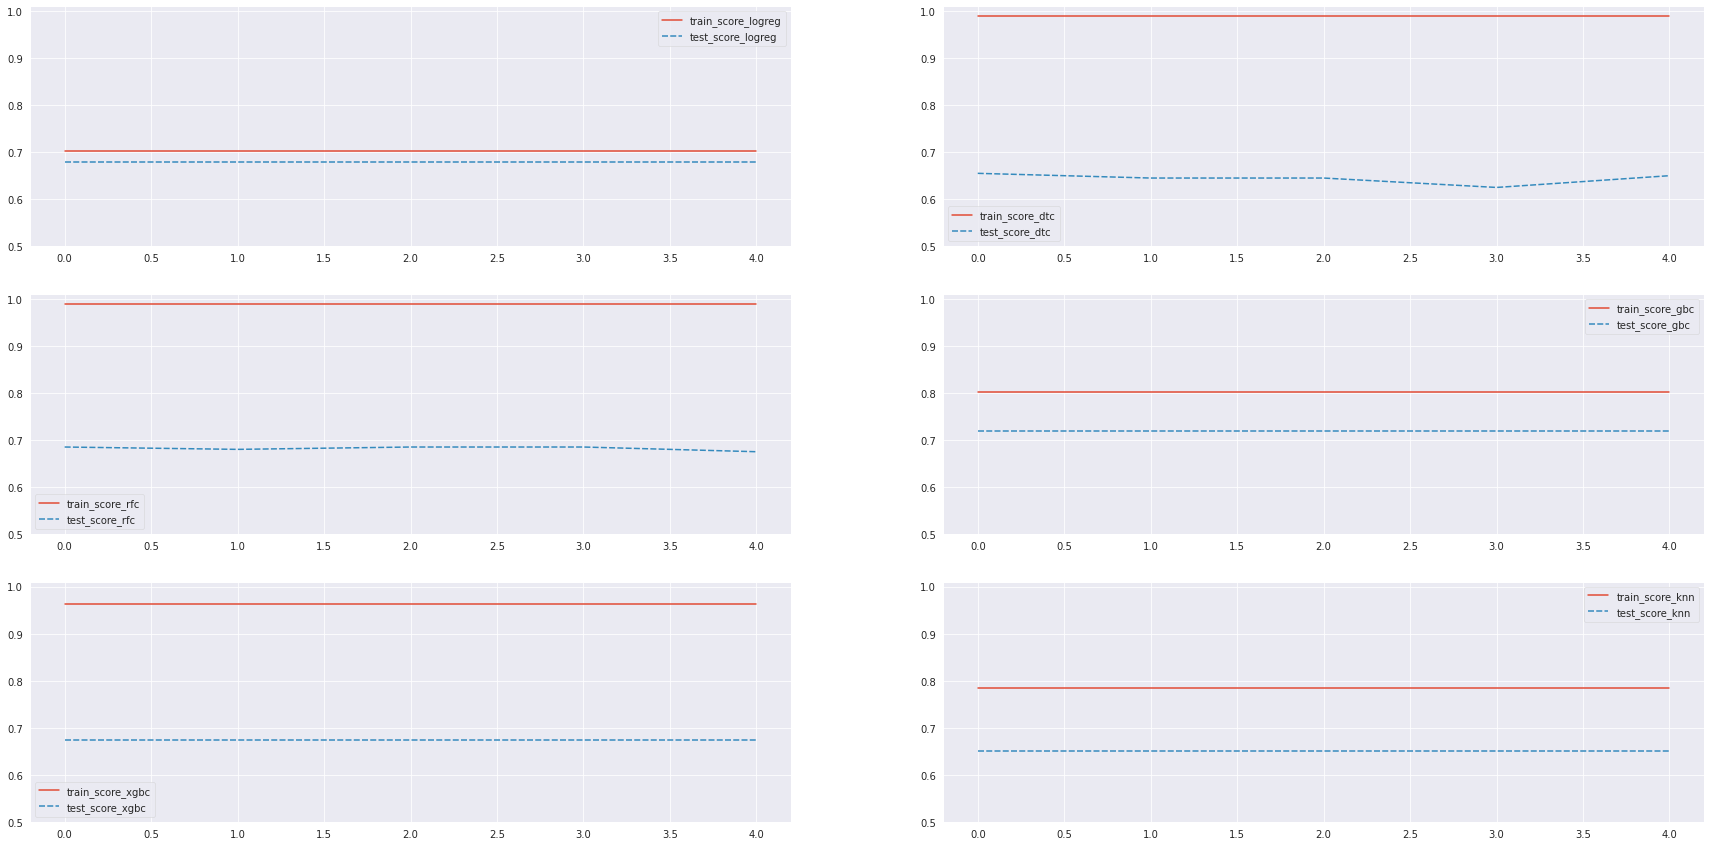

In [56]:
# Plot the score of each models
plt.figure(figsize=(30,15))

plt.subplot(321)
plt.ylim(0.5, 1.01)
sns.lineplot(data=train_vs_test[['train_score_logreg','test_score_logreg']])

plt.subplot(322)
plt.ylim(0.5, 1.01)
sns.lineplot(data=train_vs_test[['train_score_dtc','test_score_dtc']])

plt.subplot(323)
plt.ylim(0.5, 1.01)
sns.lineplot(data=train_vs_test[['train_score_rfc','test_score_rfc']])

plt.subplot(324)
plt.ylim(0.5, 1.01)
sns.lineplot(data=train_vs_test[['train_score_gbc','test_score_gbc']])

plt.subplot(325)
plt.ylim(0.5, 1.01)
sns.lineplot(data=train_vs_test[['train_score_xgbc','test_score_xgbc']])

plt.subplot(326)
plt.ylim(0.5, 1.01)
sns.lineplot(data=train_vs_test[['train_score_knn','test_score_knn']])


plt.show()

In [57]:
# Average score of each models
avg_train_score_logreg = sum(train_score_logreg)/len(train_score_logreg)
avg_test_score_logreg = sum(test_score_logreg)/len(test_score_logreg)
avg_train_score_dtc = sum(train_score_dtc)/len(train_score_dtc)
avg_test_score_dtc = sum(test_score_dtc)/len(test_score_dtc)
avg_train_score_rfc = sum(train_score_rfc)/len(train_score_rfc)
avg_test_score_rfc = sum(test_score_rfc)/len(test_score_rfc)
avg_train_score_gbc = sum(train_score_gbc)/len(train_score_gbc)
avg_test_score_gbc = sum(test_score_gbc)/len(test_score_gbc)
avg_train_score_xgbc = sum(train_score_xgbc)/len(train_score_xgbc)
avg_test_score_xgbc = sum(test_score_xgbc)/len(test_score_xgbc)
avg_train_score_knn = sum(train_score_knn)/len(train_score_knn)
avg_test_score_knn = sum(test_score_knn)/len(test_score_knn)

trainScore = [avg_train_score_logreg,avg_train_score_dtc, avg_train_score_rfc, avg_train_score_gbc, avg_train_score_xgbc, avg_train_score_knn]
testScore = [avg_test_score_logreg, avg_test_score_dtc, avg_test_score_rfc, avg_test_score_gbc, avg_test_score_xgbc, avg_test_score_knn]

# Summary of average score
avg_train_vs_test = pd.DataFrame({'trainScore':trainScore,
                                  'testScore':testScore},
                                 index = model_name
                            )

avg_train_vs_test['difference'] = avg_train_vs_test['trainScore']-avg_train_vs_test['testScore']
avg_train_vs_test

,trainScore,testScore,difference
LogisticRegression,0.7025,0.680,0.0225
DecisionTreeClassifier,0.9900,0.644,0.3460
RandomForestClassifier,0.9900,0.682,0.3080
GradientBoostingClassifier,0.8025,0.720,0.0825
XGBClassifier,0.9625,0.675,0.2875
KNeighborsClassifier,0.7850,0.650,0.1350


From the score above, it is known that Gradient Boosting Classifier has the highest accuracy score. This model will be tuned later.

In [58]:
features = list(default_models[0].named_steps['transformer'].transformers_[0][1][1].get_feature_names()) + list(default_models[1].named_steps['transformer'].transformers_[1][2])

In [59]:
# Check features used in RFE

rfe_df = pd.DataFrame({'indicator':default_models[2].named_steps['rfe'].support_, 'features':features})
# len(rfe_df[rfe_df['indicator']==True])
rfe_df[rfe_df['indicator']==True]

,indicator,features
0,True,x0_female
1,True,x0_male
2,True,x1_0
9,True,x3_little
10,True,x3_moderate
12,True,x3_rich
14,True,x4_little
15,True,x4_moderate
17,True,x4_undefined
21,True,x5_education


## Hyperparameter Tuning

In [60]:
hyperparam_gbc = {
    'clf__learning_rate':[0.1, 0.25, 0.5, 0.75]
    ,'clf__n_estimators':[100,200,300]
    ,'clf__min_samples_split':[2,5,10]
    ,'clf__max_depth':[3,5,10]
    ,'clf__criterion':['friedman_mse','mse','mae']}

In [61]:
# default_models[3]['clf']

In [62]:
# Init signature:
# GradientBoostingClassifier(
#     *,
#     loss='deviance',
#     learning_rate=0.1,
#     n_estimators=100,
#     subsample=1.0,
#     criterion='friedman_mse',
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_depth=3,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     init=None,
#     random_state=None,
#     max_features=None,
#     verbose=0,
#     max_leaf_nodes=None,
#     warm_start=False,
#     validation_fraction=0.1,
#     n_iter_no_change=None,
#     tol=0.0001,
#     ccp_alpha=0.0,
# )

In [63]:
skf = StratifiedKFold(n_splits=5)

gbc_grid = GridSearchCV(default_models[3], param_grid=hyperparam_gbc, cv=skf, verbose=1, n_jobs=-1)
gbc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat '
                                                                         'pipe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='undefined',
                                                                                                        strategy='constant')),
                                                                                         ('one '
                                                                                          'hot '
                                                                                          'encoder',
                                                      

In [64]:
# default_models[3].get_params().keys()

In [65]:
gbc_grid.best_params_

{'clf__criterion': 'friedman_mse',
 'clf__learning_rate': 0.25,
 'clf__max_depth': 3,
 'clf__min_samples_split': 10,
 'clf__n_estimators': 200}

In [66]:
pd.DataFrame(gbc_grid.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__learning_rate,param_clf__max_depth,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
34,0.907576,0.026476,0.014270,0.000485,friedman_mse,0.25,3,10,200,"{'clf__criterion': 'friedman_mse', 'clf__learn...",0.74375,0.74375,0.72500,0.68750,0.66250,0.71250,0.032355,1
142,0.911793,0.035876,0.014429,0.000882,mse,0.25,3,10,200,"{'clf__criterion': 'mse', 'clf__learning_rate'...",0.73750,0.74375,0.72500,0.68750,0.66250,0.71125,0.031225,2
316,16.564356,1.400887,0.016019,0.001071,mae,0.75,10,2,200,"{'clf__criterion': 'mae', 'clf__learning_rate'...",0.75000,0.75625,0.69375,0.69375,0.65625,0.71000,0.037832,3
212,3.001221,0.414072,0.017302,0.000917,mse,0.75,10,5,300,"{'clf__criterion': 'mse', 'clf__learning_rate'...",0.75625,0.71875,0.70625,0.70625,0.65625,0.70875,0.032016,4
296,21.169739,2.404977,0.016479,0.001049,mae,0.5,10,10,300,"{'clf__criterion': 'mae', 'clf__learning_rate'...",0.73750,0.71250,0.73125,0.70625,0.65625,0.70875,0.028668,4


In [67]:
gbc_tuned = gbc_grid.best_estimator_
gbc_tuned_score = cross_val_score(gbc_tuned, X_train, y_train, cv=skf, n_jobs=-1, verbose=1)
gbc_tuned_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


array([0.7375 , 0.74375, 0.725  , 0.6875 , 0.6625 ])

In [68]:
gbc_tuned_score.mean()

0.71125

In [69]:
print(accuracy_score(y_train, default_models[3].predict(X_train)))
print(accuracy_score(y_test, default_models[3].predict(X_test)))
print(accuracy_score(y_train, gbc_grid.best_estimator_.predict(X_train)))
print(accuracy_score(y_test, gbc_grid.best_estimator_.predict(X_test)))

0.8025
0.72
0.8975
0.69


Unfortunately the GBC model with default parameter is better than the tuned one

In [70]:
gbc_model_default = default_models[3]

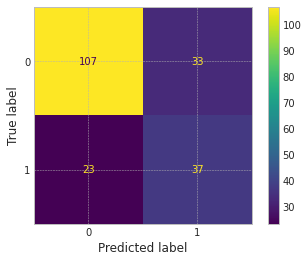

In [71]:
plt.style.use('bmh')
plot_confusion_matrix(gbc_model_default, X_test, y_test)  
plt.show()

From the confusion matrix above, the model manage help the bank to __reduce the number of application to be assessed up to 35%__. From the 200 applications, the bank only need to assess 130 applications (TN+FN = 107+23 -> all the samples that predicted as 0/good risk) and 107 of them are approved.

In [72]:
print(classification_report(y_test, gbc_model_default.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       140
           1       0.53      0.62      0.57        60

    accuracy                           0.72       200
   macro avg       0.68      0.69      0.68       200
weighted avg       0.73      0.72      0.73       200



In [73]:
print(df[df['Risk']=='good']['Credit amount'].median())
print(df[df['Risk']=='bad']['Credit amount'].median())

2244.0
2574.5


In [74]:
a=107*df[df['Risk']=='good']['Credit amount'].median()
b=4033*df[df['Risk']=='good']['Credit amount'].median()
c=16*df[df['Risk']=='bad']['Credit amount'].median()

print(f'Rev: {a}')
print(f'Expected rev: {a+b}')
print(f'Actual profit: {a-c}')

Rev: 240108.0
Expected rev: 9290160.0
Actual profit: 198916.0
